In [90]:
# Bu çalışma https://arxiv.org/abs/1612.05251 makalesinden esinlenilmiştir.
# Bu makalede yapılan model bir akademik çalışma sonucu oluşan makalenin abstract kısmını okunması daha kolay olan 5 farklı parçaya ayırıyor.
# Öncelikle verimizin ait olduğu repoyu klonlayalım (bu notebook google colab ortamında gpu kullanılarak oluşturulmuştur)
import tensorflow as tf
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [91]:
# Biz bu veri setlerinden PubMed_20k_RCT_numbers_replaced_with_at_sign'ı kullanacağız. Bu veri setinde metindeki sayılar @ işareti ile değiştirilmiştir.
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [92]:
# Veri setinin olduğu dosyadaki dev.txt validation için ayırılmış test.txt test için train.txt ise train için ayrılmış.
# Şimdi verilerimizi python listesine çekelim.

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

# Veri setimizin bulunduğu yerdeki dosya isimlerine bakalım

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [93]:
# Şimdi ise verilerimizi python listesine çekelim

def read_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

train_lines = read_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [94]:
# Görüldüğü gibi train.txt veri dosyasında preprocess etmemiz gereken bazı şeyler vardır.
# Her bir yeni paragrafın belirtisi ### ifadesiyle ve ardından gelen numarayla belli oluyor.
# Paragrafın ayrılmak istenen bölümlerini METHODS, RESULTS vs. diye labellanmış.
# Şimdi ise preprocessing yapalım.

def preprocess_text(filename):
  # Tüm cümleleri alalım
  input_lines = read_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    # Eğer yeni paragrafın başlangıcıysa boş ve değişkenimizi sonraki cümleler resetliyoruz geçiyoruz.
    if line.startswith("###"):
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        # Cümlelerde \t'den önce ayrılacağı bölüm \t'den sonra ise o bölümün yazısı vardı ona göre işlem yapalım 
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        # Bu iki farklı kolonu da ekstra fayda sağlaması için modelimizde kullanacağız.
        # line_number cümlenin numarasını, total_lines ise o paragraftaki toplam cümle sayısını veriyor.
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [95]:
# Şimdi ise tüm verilerimizi preprocess ederek işleyelim.
train_samples = preprocess_text(data_dir + "train.txt")
val_samples = preprocess_text(data_dir + "dev.txt")
test_samples = preprocess_text(data_dir + "test.txt")
# Hepsinin toplam içerdiği veri sayısına bakalım
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [96]:
# Örnek birkaç veri
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [97]:
# Verilerimizi daha kolay işlem yapabilmek için pandas dataframe'e geçirelim
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [98]:
# Hangi labellardan ne kadar var ona bakalım.
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [99]:
# Cümle sayısı dağılımına bakalım.
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [100]:
# Verilerimizin text kısmını alalım ve listeye çevirelim

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [101]:
# Şimdi labellarımızı işlem yapabilmek için one-hot encodelayalım.

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [102]:
# Şimdi ise pretrained olan embedding layer'ı oluşturalım bunun için universal-sentence-encoder(USE) modelini kullanacağız.
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [103]:
# Rastgele bir cümleye ve cümlenin embedding edilmiş haline bakalım
import random
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Embedded sentence:\n{use_embedded_sentence}")

Random sentence:
the continuous infusion arm had a greater reduction in bnp over the hospital course , ( -@ @ versus -@ @ pg/ml p = @ ) .
Embedded sentence:
[[-0.03974866 -0.03582202  0.01795535 -0.06212832 -0.04652265  0.04690869
   0.02811725 -0.03128568  0.07049067 -0.0044055   0.09080656  0.0543962
   0.0250766  -0.00266877  0.03143524 -0.05662567 -0.08746406 -0.01179072
   0.02157349 -0.00818647  0.06157339  0.06544899 -0.02736854 -0.07458206
  -0.02634914  0.01652463 -0.04296027 -0.02147532 -0.05579996 -0.00375862
   0.04994873  0.09239149  0.03055449 -0.07197479 -0.02043013  0.01141405
   0.00700919  0.02484487 -0.07347038 -0.00359356  0.04535966  0.03337784
  -0.01170001  0.02924598  0.01785416  0.01622536  0.01226483  0.06400326
  -0.07165068  0.04581199 -0.03217793  0.01982397  0.02550727  0.02423852
   0.01092992  0.04138428 -0.03147275 -0.09054489 -0.01159341 -0.07893281
  -0.03147742  0.08198345  0.05259802 -0.0004246  -0.0113003   0.03425997
   0.02832288 -0.03705887  0.0

In [104]:
# Kelimeleri embedding etme kısmı bitti şimdi ise makalede olduğu gibi character embedding layer'ını oluşturalım
def split_characters(text):
  return " ".join(list(text))

print(random_train_sentence)
print(split_characters(random_train_sentence))

train_chars = [split_characters(sentence) for sentence in train_sentences]
val_chars = [split_characters(sentence) for sentence in val_sentences]
test_chars = [split_characters(sentence) for sentence in test_sentences]

train_chars[:1]

the continuous infusion arm had a greater reduction in bnp over the hospital course , ( -@ @ versus -@ @ pg/ml p = @ ) .
t h e   c o n t i n u o u s   i n f u s i o n   a r m   h a d   a   g r e a t e r   r e d u c t i o n   i n   b n p   o v e r   t h e   h o s p i t a l   c o u r s e   ,   (   - @   @   v e r s u s   - @   @   p g / m l   p   =   @   )   .


['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .']

(array([3.6010e+03, 1.8507e+04, 3.2553e+04, 3.8030e+04, 3.2045e+04,
        2.1907e+04, 1.4198e+04, 8.1930e+03, 4.7480e+03, 2.7060e+03,
        1.3630e+03, 8.7200e+02, 5.1900e+02, 2.8300e+02, 1.8300e+02,
        1.0400e+02, 6.7000e+01, 5.1000e+01, 3.3000e+01, 1.6000e+01,
        1.4000e+01, 1.5000e+01, 5.0000e+00, 8.0000e+00, 4.0000e+00,
        4.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000000e+00, 3.562500e+01, 7.025000e+01, 1.048750e+02,
        1.395000e+02, 1.741250e+02, 2.087500e+02, 2.433750e+02,
        2.780000e+02, 3.126250e+02, 3.472500e+02, 3.818750e+02,
        4.165000e+02, 4.511250e+02, 4.857500e+02, 5.203750e+02,
        5.550000e+02, 5.896250e+02, 6.242500e+02, 6.588750e+02,
        6.935000e+02, 7.281250e+02, 7.627500e+02, 7.973750e+02,
        8.320000e+02, 8.666250e+02, 9.012500e+02, 9.358750e+02,
      

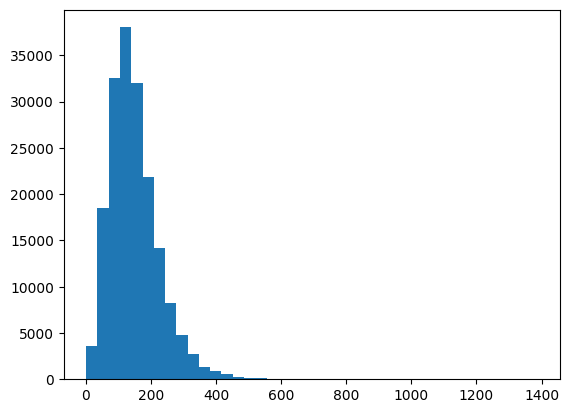

In [105]:
# Şimdi ise character embedding layer'ımızı oluşturalım öncelikle output_sequence_length değişkenine vereceğimiz değeri bulmak için verilerimizin %99'unu kaplayacak değeri bulalım
chars_len = [len(sentence) for sentence in train_sentences]
import matplotlib.pyplot as plt
plt.hist(chars_len, bins=40)

In [106]:
import numpy as np
characters_output_sequence_length = int(np.percentile(chars_len, 99))
characters_output_sequence_length

395

In [107]:
# character embedding layer'ı için tüm karakterleri alalım
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [108]:
# Şimdi ise tokenizer'ı oluşturalım
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
NUM_CHAR_TOKENS = len(alphabet) + 2 # +2 ekledik çünkü boşluk karakteri ve OOV(out of vocabulary) karakterleri yok
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=characters_output_sequence_length,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [109]:
# Oluşan token sözlüğünü inceleyelim
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [110]:
# Şimdi ise bir örneği inceleyelim
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   t o t a l   e f f e c t i v e   r a t e s   o f   c h i n e s e   m e d i c a l   s y m p t o m   i n t e g r a l s   a n d   t c s s   s c o r e   w e r e   o b v i o u s l y   h i g h e r   i n   t h e   t r e a t m e n t   g r o u p   t h a n   i n   t h e   c o n t r o l   g r o u p   (   p   <   @   )   .

Length of chars: 131

Vectorized chars:
[[ 3 13  2  3  7  3  5 12  2 17 17  2 11  3  4 21  2  8  5  3  2  9  7 17
  11 13  4  6  2  9  2 15  2 10  4 11  5 12  9 19 15 14  3  7 15  4  6  3
   2 18  8  5 12  9  5  6 10  3 11  9  9  9 11  7  8  2 20  2  8  2  7 22
  21  4  7 16  9 12 19 13  4 18 13  2  8  4  6  3 13  2  3  8  2  5  3 15
   2  6  3 18  8  7 16 14  3 13  5  6  4  6  3 13  2 11  7  6  3  8  7 12
  18  8  7 16 14 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0

In [111]:
# Embedding layer'ı hazırlayalım
from tensorflow.keras import layers
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

In [112]:
# Örnek cümleye bakalım
print(f"Charified text(before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorizationand embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text(before vectorization and embedding):
t h e   t o t a l   e f f e c t i v e   r a t e s   o f   c h i n e s e   m e d i c a l   s y m p t o m   i n t e g r a l s   a n d   t c s s   s c o r e   w e r e   o b v i o u s l y   h i g h e r   i n   t h e   t r e a t m e n t   g r o u p   t h a n   i n   t h e   c o n t r o l   g r o u p   (   p   <   @   )   .

Embedded chars (after vectorizationand embedding):
[[[-0.02184054 -0.02111895  0.0058763  ...  0.04749496 -0.03433776
    0.03016916]
  [ 0.04436849  0.02762181  0.03952051 ... -0.02136856 -0.01893201
   -0.0078989 ]
  [-0.03807675 -0.0286361  -0.0178919  ... -0.03650143  0.04880441
    0.03698692]
  ...
  [-0.01500623  0.03529577 -0.00127167 ... -0.00877334 -0.03223965
    0.01248331]
  [-0.01500623  0.03529577 -0.00127167 ... -0.00877334 -0.03223965
    0.01248331]
  [-0.01500623  0.03529577 -0.00127167 ... -0.00877334 -0.03223965
    0.01248331]]]

Character embedding shape: (1, 395, 25)


<Axes: ylabel='Frequency'>

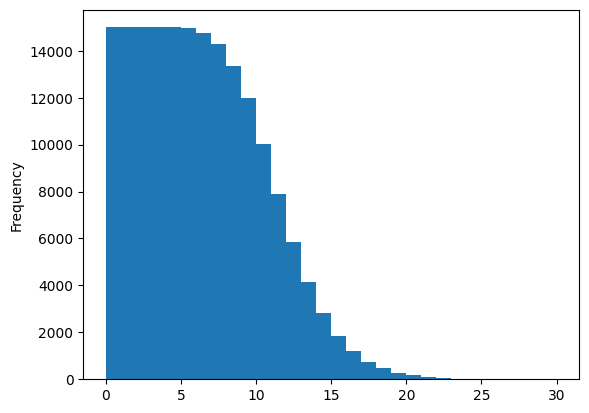

In [113]:
# Şimdi ise modelimizi desteklemesi için diğer özellikleri hazırlayalım (line_number ve total_lines)
# Bu labelları kullanabilmek için one-hot codelamamız lazım ancak depth'i kaç olacak bunu bulmamız lazım yukarıda uyguladığımız yöntemin aynısını uyguluyoruz
train_df.line_number.plot.hist(bins=30)

In [114]:
line_number_depth = int(np.percentile(train_df.line_number.to_numpy(), 99))
line_number_depth

17

In [115]:
total_lines_depth = int(np.percentile(train_df.total_lines.to_numpy(), 99))
total_lines_depth

21

In [116]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=line_number_depth)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=line_number_depth)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=line_number_depth)

train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=total_lines_depth)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=total_lines_depth)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=total_lines_depth)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape, train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 17), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]], dtype=float32)>,
 TensorShape([180040, 17]),
 <tf.Tensor: shape=(10, 21), dtyp

In [117]:
# Artık modelimizi oluşturabiliriz..
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

line_number_inputs = layers.Input(shape=(line_number_depth,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

total_lines_inputs = layers.Input(shape=(total_lines_depth,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                total_line_model.output,
                                                                                z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

model = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                                 outputs=output_layer)

In [118]:
# Bir callback oluşturalım.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0)

# Modeli compile edelim
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer='adam',
                metrics=["accuracy"])

In [119]:
# Modelimizin daha hızlı çalışması için verilerimizi tf.data.Dataset'e çevirelim
# Modelde daha hızlı çalışmaları için veri setlerini prefetchleyeceğiz (bir batch işlenirken diğer batch hazırlanır böylece işlem daha hızlı olur)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [121]:
# Modeli fit edelim
history = model.fit(train_char_token_pos_dataset,
                    steps_per_epoch=len(train_char_token_pos_dataset),
                    epochs=100,
                    validation_data=val_char_token_pos_dataset,
                    # Modelin daha hızlı çalışması için validation datasetin %10'u üzerinde validation yapıyoruz.
                    validation_steps=int(0.1*len(val_char_token_pos_dataset)),
                    callbacks=[callback])

Epoch 1/100
5627/5627 [==============================] - 256s 46ms/step - loss: 0.9095 - accuracy: 0.8533 - val_loss: 0.9003 - val_accuracy: 0.8523
Epoch 2/100
5627/5627 [==============================] - 204s 36ms/step - loss: 0.8980 - accuracy: 0.8613 - val_loss: 0.8997 - val_accuracy: 0.8543
Epoch 3/100
5627/5627 [==============================] - 204s 36ms/step - loss: 0.8890 - accuracy: 0.8683 - val_loss: 0.9005 - val_accuracy: 0.8523


In [122]:
# Model ile predict etmek için test datasetini oluşturalım.
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [123]:
# Test dataset'i üzerinde modelimiz ile predict yapalım
preds = tf.argmax(model.predict(test_pos_char_token_dataset, verbose=0), axis=1)

# Modelimizi değerlendirelim (ayrıca test labellarını encode etmemiz lazım)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
model_accuracy = accuracy_score(test_labels_encoded, preds) * 100
model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels_encoded, preds, average="weighted")
model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
model_results

{'accuracy': 84.78845196615231,
 'precision': 0.8482870668371613,
 'recall': 0.8478845196615231,
 'f1': 0.8450955076162536}